#  Task B - Compare Segmentation Methods

## CE6003 - Module Intro, Classical Image Processing, Classification and Detection

### Seamus Brady 18195148

This is a quick and naive attempt at using OpenCV versus K-Means clustering for image segmentation.

I wanted to do a simple "Stackoverflow" cargo-cult programme[1] attempt at seperating out a pedestrian from the background.

The idea is that I have been given an afternoon by Elon Musk to complete the pedestrian recognition algorithm for the new Tesla which is shipping tomorrow. 

I need to have the best working algorithm in the least amount of time possible...


I just wanted to get a quick idea of the following:

- How simple would it be to seperate out a human figure from a background using OpenCV?
- How simple would it be using K-Means?

This is a very crude experiment and the code below should not be used in a real self-driving car.

[1] https://en.wikipedia.org/wiki/Cargo_cult_programming


### Attempt 1 - Use OpenCV to seperate out a pedestrian

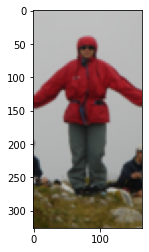

In [28]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import * 
%matplotlib inline

# Load a color image
img1 = cv2.imread("inria_pedestrian.png")

plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

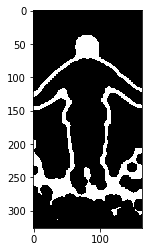

In [27]:
# an ugly attempt, let's hope Elon does not do code reviews...
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# I tried playing around with this but there are two many options!!
for e in range(0, 2):
    eroded = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, elKernel)
ret, otsu = cv2.threshold(eroded, 127, 127, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
close = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, closingKernel)
plt.imshow(close, cmap='gray')

It looks relatively OK, we sort of have a human outline.

Let's see if we can get the figure seperated...

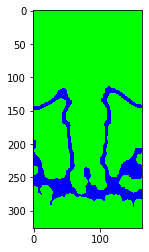

In [20]:
_, contours, _ = cv2.findContours(close.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

for c in contours:
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]
mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

We appear to be OK once our pedestrians have no heads!

### Attempt 2 - Use K-Means to seperate out a pedestrian

Obviously I will use built in K-Means as it is quicker...

100%|##########| 326/326 [00:00<00:00, 1559.46it/s]


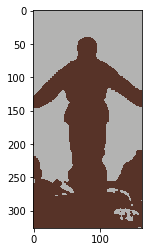

In [29]:
img2 = Image.open("inria_pedestrian.png")
imgWidth = img2.size[0]
imgHeight = img2.size[1]
numFeatures = 7
Z = np.ndarray(shape=(imgWidth * imgHeight, numFeatures), dtype = float)
Z = np.float32(Z)

for y in tqdm(range(0, imgHeight), ascii=True):
    for x in range(0, imgWidth):
        xy = (x, y)
        rgb = img2.getpixel(xy)
        Z[x + y * imgWidth, 0] = rgb[0]           # blue
        Z[x + y * imgWidth, 1] = rgb[1]           # green
        Z[x + y * imgWidth, 2] = rgb[2]           # red
        # Experimentally, reduce the influence of the x,y components by dividing them by 10
        Z[x + y * imgWidth, 3] = x / 10           # x
        Z[x + y * imgWidth, 4] = y / 10           # y 
        Z[x + y * imgWidth, 5] = rgb[2] - rgb[0]  # red - blue
        Z[x + y * imgWidth, 6] = rgb[2] - rgb[1]  # red - green


K = 2
clusterCenters = np.ndarray(shape=(K,numFeatures))

for i, _ in enumerate(clusterCenters):
        clusterCenters[i] = np.random.uniform(minVals, maxVals, numFeatures)

# OpenCV's K-means 
criteria = (cv2.TERM_CRITERIA_MAX_ITER, i+1, 0.1)
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert center back into unsigned bytes
center = np.uint8(center)

# reshape the RGB values from our cv2.kmeans results into
# an image.
rgb = center[:,0:3]
res = rgb[label.flatten()]
img = res.reshape((imgHeight,imgWidth, 3))

plt.imshow(img)


Much better! This pedestrian seems to have a head *and* a body.

### Conclusion

Neither "algorithm" is great but the K-Means would be better.

I doubt Elon will be happy but that is the best I can offer in so little time :)